In [2]:
# Load the main libraries and define some functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, RFE, RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import re
from sklearn.base import TransformerMixin
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print ("Best parameters:", gs.best_params_)
    best = gs.best_estimator_
    return best

# Save classification report as pandas dataframe
def to_table(report):
    report = report.splitlines()
    res = []
    res.append(['']+report[0].split())
    for row in report[2:-2]:
       res.append(row.split())
    lr = report[-1].split()
    res.append([' '.join(lr[:3])]+lr[3:])
    return np.array(res)

def clsf_df(ytest, ypred):
    classification_scores = to_table(classification_report(ytest, ypred))
    df = pd.DataFrame(data = classification_scores[1:4], columns = classification_scores[0])
    return df

def do_classify(clf, parameters, Xtrain, ytrain, Xtest, ytest, score_func=None, n_folds=5, n_jobs=1):
   
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print ('Confusion Matrix:')
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ('Classification Report:')
    print (clsf_df(ytest, clf.predict(Xtest)))
    #print (classification_report(ytest, clf.predict(Xtest)))
    print ("########################################################")
    return clf



def do_regress(estimator, Xtrain, ytrain, Xtest, ytest, parameters = None, score_func=None, n_folds=5, n_jobs=1):  
    if parameters:
        estimator = cv_optimize(estimator, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    estimator=estimator.fit(Xtrain, ytrain)
    cv_results = cross_val_score(estimator, Xtrain, ytrain, cv = 5)
    ypred = estimator.predict(Xtest)
    rsquared_train = np.mean(cv_results)
    rsquared_test = estimator.score(Xtest,  ytest)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    return rsquared_train, rsquared_test, rmse
    
def plot_coef(plot_title, estimator, X_train, y_train):
    names = X_train.columns
    coef = estimator.fit(X_train, y_train).coef_
    plt.figure(figsize=(16,7))
    _ = plt.plot(range(len(names)), coef)
    _ = plt.xticks(range(len(names)), names, rotation = 90)
    _ = plt.ylabel('Coefficients')
    _ = plt.title(plot_title)
    plt.show()

def plot_feature_importance(clf, name_list, chart_title):
    importance_list = clf.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))

    plt.figure(figsize = (10, 10))
    plt.barh(range(len(name_list)),importance_list,align='center')
    plt.yticks(range(len(name_list)),name_list)
    plt.ylabel('Features')
    plt.title('Relative importance of Each Feature in %s' %(chart_title))
    plt.show()

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

In [3]:
# Import raw dataset
df = pd.read_table('Data/cup98LRN.txt', sep = ',', low_memory = False, na_values = ' ')

# I. Dataset Introduction
* This is the data set used for The Second International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-98 The Fourth International Conference on Knowledge Discovery and Data Mining. 
* The dataset used in this project is the Training set used in the competition. It includes:
    * 95412 rows, 481 columns
    * Each record has a unique identifier, personal attributes, as well as donation history.
    * Each record has two target/dependent variables: TARGET_B and TARGET_D. TARGET_B is a binary variable indicating whether or not the record responded to the promotion of interest ("97NK" mailing) while TARGET_D contains the donation amount (dollar) and is only observed for those that responded to the promotion.

# II. Data Wrangling

### II-1. Explore original dataset, then create a balanced subset

In [4]:
df.shape

(95412, 481)

In [5]:
# View the original dataset
df.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,GENDER,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,SOLP3,SOLIH,MAJOR,WEALTH2,GEOCODE,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,PETS,CDPLAY,STEREO,PCOWNERS,PHOTO,CRAFTS,FISHER,GARDENIN,BOATS,WALKER,KIDSTUFF,CARDS,PLATES,LIFESRC,PEPSTRFL,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_5,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_10,ADATE_11,ADATE_12,ADATE_13,ADATE_14,ADATE_15,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_20,ADATE_21,ADATE_22,ADATE_23,ADATE_24,RFA_2,RFA_3,RFA_4,RFA_5,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RDATE_3,RDATE_4,RDATE_5,RDATE_6,RDATE_7,RDATE_8,RDATE_9,RDATE_10,RDATE_11,RDATE_12,RDATE_13,RDATE_14,RDATE_15,RDATE_16,RDATE_17,RDATE_18,RDATE_19,RDATE_20,RDATE_21,RDATE_22,RDATE_23,RDATE_24,RAMNT_3,RAMNT_4,RAMNT_5,RAMNT_6,RAMNT_7,RAMNT_8,RAMNT_9,RAMNT_10,RAMNT_11,RAMNT_12,RAMNT_13,RAMNT_14,RAMNT_15,RAMNT_16,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,NaN,NaN,3712,0,NaN,NaN,NaN,NaN,XXXX,T2,36.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,39,34,18,10,2,1,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,

In [6]:
# Share of the TARGET_B variable
df.TARGET_B.mean()

0.05075881440489666

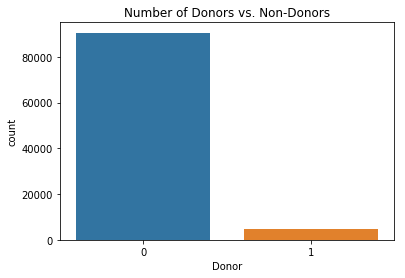

In [7]:
# Plot number of donors vs. non-donors
sns.countplot(data = df, x = 'TARGET_B')
plt.xlabel('Donor')
plt.title('Number of Donors vs. Non-Donors')
plt.show()


Since the dataset is highly imbalanced (only 5% of the samples are donors), I'll create a balanced subset to make it 
easier for modeling later. 

In [8]:
# Subset where TARGET_B is 1
df_target1 = df.loc[df.TARGET_B == 1]
# Subset where TARGET_B is 0. Randomly select 10000 samples
df_target0 = df.loc[df.TARGET_B == 0].sample(n = 10000, replace = False, random_state = 123)
# Concatenate these two subsets to create a subset where TARGET_B has both 0 and 1 values
df_subset = pd.concat([df_target1, df_target0])
df_subset.shape


(14843, 481)

In [9]:
# Check the share of donors in the new dataset
df_subset.TARGET_B.mean()

0.32628174897257967

Now 32.6% of the samples are donors

### II-2. Check missing values. Drop features which have >= 30% of missing values

In [11]:
# Check missing values
missing_percent = []
for col in df_subset.columns:
    percent_missing = df_subset[col].isnull().sum()/len(df_subset) * 100
    missing_percent.append(percent_missing)

missing_table = list(zip(df_subset.columns, missing_percent))
missing_table = pd.DataFrame(missing_table, columns = ['Feature', 'Percent of Missing Values'])
missing_table = missing_table.sort_values(by = 'Percent of Missing Values', ascending = False)
missing_table.head(10)
    

,Feature,Percent of Missing Values
414,RDATE_5,99.973051
436,RAMNT_5,99.973051
11,RECPGVG,99.824833
50,SOLP3,99.764199
413,RDATE_4,99.636192
435,RAMNT_4,99.636192
52,MAJOR,99.636192
412,RDATE_3,99.562083
434,RAMNT_3,99.562083
72,PLATES,99.346493


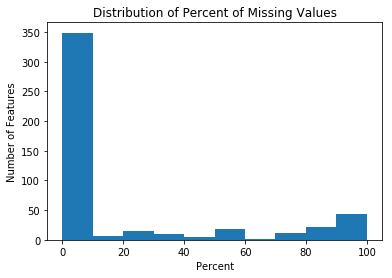

In [12]:
# Plot the distribution of percentage of missing values by feature
plt.hist(x = missing_table['Percent of Missing Values'])
plt.title('Distribution of Percent of Missing Values')
plt.ylabel('Number of Features')
plt.xlabel('Percent')
plt.show()

In [13]:
# View features with >30% missing values
missing_30pct = missing_table.loc[missing_table['Percent of Missing Values'] >= 30]
print (len(missing_30pct))
print (missing_30pct.Feature.unique())

112
['RDATE_5' 'RAMNT_5' 'RECPGVG' 'SOLP3' 'RDATE_4' 'RAMNT_4' 'MAJOR'
 'RDATE_3' 'RAMNT_3' 'PLATES' 'HOMEE' 'RDATE_6' 'RAMNT_6' 'CHILD03' 'CARDS'
 'MAILCODE' 'KIDSTUFF' 'CHILD07' 'PVASTATE' 'RECSWEEP' 'CHILD12' 'BOATS'
 'RECP3' 'CHILD18' 'PHOTO' 'COLLECT1' 'SOLIH' 'FISHER' 'RECINHSE'
 'RDATE_20' 'RAMNT_20' 'RDATE_15' 'RAMNT_15' 'CATLG' 'CRAFTS' 'RAMNT_23'
 'RDATE_23' 'BIBLE' 'RAMNT_7' 'RDATE_7' 'RDATE_21' 'RAMNT_21' 'RAMNT_17'
 'RDATE_17' 'PCOWNERS' 'RDATE_10' 'RAMNT_10' 'VETERANS' 'WALKER' 'NUMCHLD'
 'CDPLAY' 'STEREO' 'GARDENIN' 'RAMNT_13' 'RDATE_13' 'PETS' 'RDATE_11'
 'RAMNT_11' 'GEOCODE' 'RDATE_19' 'RAMNT_19' 'RAMNT_9' 'RDATE_9' 'RDATE_24'
 'RAMNT_24' 'RAMNT_18' 'RDATE_18' 'RDATE_22' 'RAMNT_22' 'RDATE_8' 'RAMNT_8'
 'RDATE_14' 'RAMNT_14' 'RAMNT_12' 'RDATE_12' 'RDATE_16' 'RAMNT_16' 'RFA_15'
 'ADATE_15' 'RFA_23' 'ADATE_23' 'LIFESRC' 'MBCOLECT' 'MBCRAFT' 'MAGFAML'
 'PUBDOITY' 'MAGMALE' 'MAGFEM' 'PUBOPP' 'MBBOOKS' 'MBGARDEN' 'PUBCULIN'
 'PUBNEWFN' 'PUBPHOTO' 'PUBHLTH' 'PUBGARDN' 'RFA_20

Almost a quarter of the Features have More than 30% Missing Values. Will drop all these features.

In [14]:
# Drop the above features -- those with >= 30% missing values
df_new = df_subset.drop(list(missing_30pct.Feature), axis = 1)
df_new.shape

(14843, 369)

### II-3. Clean Categorical Variables

In [15]:
# Find all categorical variables and the values under them
for col in df_new.columns:
    if df_new[col].dtypes == 'object':
        print ('Values in {col}: {xyz}'.format(col = col, xyz = df_new[col].unique()))

Values in OSOURCE: ['BBK' 'SYN' 'DRK' 'BHG' 'L01' 'ARG' 'L04' 'SYC' 'IMP' 'ASC' 'PV3' 'MON'
 'AML' 'FOR' 'DNA' 'ALZ' 'LIS' 'L25' 'HHH' 'APP' 'IMA' 'RPH' 'STA' 'HAN'
 'AHC' 'MBC' 'CWR' 'L15' 'SSS' 'AMB' 'AGR' 'NSH' 'ESN' 'FRC' 'STL' 'DON'
 'AKM' 'YAL' 'L03' 'DCD' 'CNT' 'KIP' 'HOS' nan 'HAM' 'WKB' 'STV' 'SPR'
 'HJR' 'MST' 'COK' 'SHM' 'PRV' 'HHS' 'HCC' 'TRN' 'SPG' 'DBL' 'PCL' 'ASK'
 'DUR' 'FOS' 'SHE' 'MCC' 'LEO' 'RAY' 'OMH' 'LHJ' 'HOW' 'WLW' 'L21' 'MCO'
 'ADD' 'L02' 'BAN' 'OLD' 'BOA' 'PBL' 'TVG' 'HEL' 'CFI' 'MYO' 'ENQ' 'PTP'
 'TRV' 'SGI' 'NAS' 'TVH' 'PME' 'DEL' 'NAD' 'GRI' 'MSE' 'FLM' 'PLU' 'CRG'
 'NEX' 'MAT' 'MAD' 'SUN' 'STR' 'AGS' 'CFF' 'KEN' 'DHR' 'GUR' 'SPN' 'L06'
 'NOR' 'WRG' 'ACT' 'QNT' 'AIR' 'OUL' 'NWN' 'EAS' 'THM' 'SPC' 'SHU' 'TPS'
 'FCR' 'COH' 'UCA' 'MB1' 'VSH' 'TOR' 'TRO' 'USB' 'CRT' 'PBK' 'NSL' 'MBB'
 'HFS' 'ACS' 'DDA' 'RED' 'HSP' 'ASE' 'KNG' 'HHL' 'GPS' 'CHK' 'MM3' 'GDA'
 'DOW' 'MIC' 'BRE' 'VAE' 'SMC' 'RMG' 'TX2' 'GRT' 'LIF' 'ANN' 'NTW' 'JUD'
 'LVT' 'CAW' 'IWD' 'COS' 'SCL' 'HE

* Will drop the RFA features (RFA_2 through RFA_22), as well as OSOURCE, ZIP, STATE, and MDMAUD

In [16]:
#Find all RFA features
drop_vars = list(df_new.columns[df_new.columns.get_loc('RFA_2'):df_new.columns.get_loc('RFA_22')+1])

# Add OSOURCE, ZIP, STATE, MDMAUD to the List the features to drop
drop_vars.extend(['OSOURCE', 'ZIP', 'STATE', 'MDMAUD'])

# Drop the above features                        
df_new = df_new.drop(drop_vars, axis = 1)

df_new.shape

(14843, 350)

* The DOMAIN feature is a matrix code, which could be broken into 2 variables: Urbanicity level of the donor (1st byte), and Socio-economic status of the donor (2nd byte).

In [17]:
# Check current values in the DOMAIN feature
df_new.DOMAIN.unique()

array(['S1', 'T1', 'C1', 'S2', 'T2', 'R2', 'C2', 'U1', 'R3', nan, 'U3',
       'U2', 'C3', 'R1', 'T3', 'S3', 'U4'], dtype=object)

In [18]:
# Split DOMAIN into 2 variables: URBAN and SES
df_new['URBAN'] = df_new['DOMAIN'].str[0]
df_new['SES'] = df_new['DOMAIN'].str[1]
df_new = df_new.drop('DOMAIN', axis = 1)  #Drop the DOMAIN feature after spliting it
print (df_new.URBAN.unique())
print (df_new.SES.unique())   #Notice that SES is of string type. Will need to convert it to numerical later.


['S' 'T' 'C' 'R' 'U' nan]
['1' '2' '3' nan '4']


In [19]:
# Recode nan values in SES as 0, and convert this feature into numeric
df_new.SES = df_new.SES.fillna(0)
df_new.SES = df_new.SES.astype(int)
df_new.SES.value_counts()

2    7157
1    4549
3    2502
0     385
4     250
Name: SES, dtype: int64

* The GENDER feature has strange values. Will change them into NaN and impute with the mode later

In [20]:
# Current values in the GENDER feature
df_new.GENDER.value_counts()

F    8018
M    6016
U     277
J      68
A       2
C       1
Name: GENDER, dtype: int64

In [21]:
# If Gender = 'F' assign value 1, if 'M' assigne 0. Others become NaN.
gender_dict = {'F': 1, 'M': 0}
df_new.GENDER = df_new.GENDER.loc[df_new.GENDER.isin(['F', 'M'])].map(gender_dict)
df_new.GENDER.value_counts()

1.0    8018
0.0    6016
Name: GENDER, dtype: int64

* NaN values in other categorical features will be imputed with the mode later.

### II-4. Clean Numeric Features

In [22]:
# First, create a list of columns which are numerical
num_cols = []
for col in df_new.columns:
    if df_new[col].dtype in ['int32', 'int64', 'float32', 'float64']:
        num_cols.append(col)
        
#print (num_cols)
df_new[num_cols].describe()

,ODATEDW,TCODE,DOB,CLUSTER,AGE,INCOME,GENDER,HIT,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,ADATE_2,ADATE_3,ADATE_4,ADATE_6,ADATE_7,ADATE_8,ADATE_9,ADATE_11,ADATE_12,ADATE_14,ADATE_16,ADATE_17,ADATE_18,ADATE_19,ADATE_22,CARDPROM,MAXADATE,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,CONTROLN,TARGET_B,TARGET_D,HPHONE_D,RFA_2F,CLUSTER2,SES
count,14843.000000,14843.000000,14843.000000,14458.000000,11171.000000,11502.000000,14034.000000,14843.000000,11502.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.00000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14827.000000,14827.000000,14827.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.00000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000

In [23]:
# Drop unimportant numeric features
df_new = df_new.drop(['TCODE','DOB','MSA', 'ADI', 'DMA', 'CONTROLN', 'ADATE_2', 'ADATE_3', 'ADATE_4', 
            'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_11', 'ADATE_12', 'ADATE_14', 
            'ADATE_16', 'ADATE_17','ADATE_18', 'ADATE_19', 'ADATE_22'], axis = 1)
df_new.shape

(14843, 330)

In [24]:
# Check the remaining DATE features
date_cols = []
pattern_date = '.*DATE.*'

for col in df_new.columns:
    if re.match(pattern_date, col):
        date_cols.append(col)
        #X_new[col] = X_new[col].astype(str)
        
df_new[date_cols].describe()

,ODATEDW,MAXADATE,MINRDATE,MAXRDATE,LASTDATE,FISTDATE,NEXTDATE
count,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,14843.000000,13453.000000
mean,9125.465202,9701.629253,9250.775450,9433.541804,9550.722159,9120.905275,9139.210436
std,344.294048,5.770651,266.946577,182.406882,50.673462,319.057961,296.150752
min,8601.000000,9608.000000,8505.000000,8312.000000,9503.000000,7401.000000,7401.000000
25%,8801.000000,9702.000000,9012.000000,9407.000000,9510.000000,8809.000000,8902.000000
50%,9101.000000,9702.000000,9306.000000,9506.000000,9512.000000,9111.000000,9201.000000
75%,9501.000000,9702.000000,9503.000000,9512.000000,9602.000000,9409.000000,9407.000000
max,9701.000000,9702.000000,9702.000000,9702.000000,9702.000000,9603.000000,9702.000000


In [25]:
# Covert these dates to the number of months difference from July 1998
for col in date_cols:
    df_new[col] = df_new[col].replace(0, None)

def month_cal(YYMM):  #Calculate number of months equivalent for the YYMM
    return int(str(YYMM)[0:2])*12 + int(str(YYMM)[2:4])

def month_diff(input_month, milestone = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(milestone) - month_cal(input_month) 

for col in date_cols:
    df_new['SINCE_'+ col] = df_new[col].apply(month_diff)

df_new = df_new.drop(date_cols, axis = 1)
df_new.shape

(14843, 330)

### II-5. Impute Missing Values

In [26]:
# See how many missing values there are in each column.
df_new.isnull().sum().sort_values(ascending = False).head()

AGE               3672
HOMEOWNR          3518
DATASRCE          3341
INCOME            3341
SINCE_NEXTDATE    1390
dtype: int64

In [27]:
# There are lots of missing values in almost all columns. Will impute them with the mode for numerical features and 
# with the most frequent values for categorical features in order to preserve the values with the highest frequency.


class Missing_Imputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Imputation of missing values. freq for nominal, median for numeric

missing_recode = Missing_Imputer()
missing_recode.fit(df_new)
df_impute = missing_recode.transform(df_new)
    
# X_impute = DataFrameImputer().fit_transform(X_new)
df_impute.head()

,NOEXCH,CLUSTER,AGE,HOMEOWNR,INCOME,GENDER,HIT,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,TARGET_B,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2,URBAN,SES,SINCE_ODATEDW,SINCE_MAXADATE,SINCE_MINRDATE,SINCE_MAXRDATE,SINCE_LASTDATE,SINCE_FISTDATE,SINCE_NEXTDATE
20,0,12.0,62.0,H,3.0,1.0,10,3.0,2,25,40,27,11,4,1,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12.0,4.066667,1,4.0,1,L,3,D,X,X,X,3.0,A,S,1,138,17,126,51,28,138,126.0
30,0,35.0,63.0,H,4.0,0.0,0,3.0,1,37,58,16,8,1,5,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9.0,6.181818,1,7.0,1,L,3,D,X,X,X,14.0,A,T,1,102,20,99,66,31,99,90.0
45,0,24.0,66.0,H,5.0,1.0,5,3.0,0,33,24,39,6,5,1,2160,683,900,89,0,11,48,52,99,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,42,47,49,40,48,50,20,33,42,25,7,14,23,21,17,13,5,14,13,33,22,18,24,7,22,22,43,35,19,6,1,72,7,5,16,165,240,69,58,1,28,27,4,0,0,0,1282,1399,5,4,96,4,97,3,8,27,76,71,25,89,11,2,0,2,9,18,2,16,62,21,0,0,0,15,33,74,88,98,2,0,70,67,67,13,3,28,0,0,2,

In [28]:
# Check that there are no more missing values
df_impute.isnull().sum().sort_values(ascending = False).head(5)

SINCE_NEXTDATE    0
HHD10             0
HHD12             0
ETHC1             0
ETHC2             0
dtype: int64

Now all of the categorical and numerical features have the correct data type and mising values have been imputed. Unimportant features have also been dropped.

### II-6. Create dummy variables from categorical features

In [29]:
# Create a list of features to turn into dummies
to_dummy = []
for col in df_impute.columns:
    if df_impute[col].dtype == 'object':
        to_dummy.append(col)
print (to_dummy)

['NOEXCH', 'HOMEOWNR', 'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'GEOCODE2', 'URBAN']


In [30]:
# Function to dummy all the categorical variables used for modeling
def dummy_df(df, to_dummy):
    for x in to_dummy:
        dummies = pd.get_dummies(df[x], prefix = x)
        df = df.drop(x, 1)    #Drop the original variable after dummying
        df = pd.concat([df, dummies], axis=1)
    return df

df_dummy = dummy_df(df_impute, to_dummy)
df_dummy.shape

(14843, 353)

In [31]:
#Check the shape of the new data frame
print (df.shape)
print (df_new.shape)
print (df_dummy.shape)

(95412, 481)
(14843, 330)
(14843, 353)


In [32]:
df_dummy.head()

,CLUSTER,AGE,INCOME,GENDER,HIT,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,TARGET_B,TARGET_D,HPHONE_D,RFA_2F,CLUSTER2,SES,SINCE_ODATEDW,SINCE_MAXADATE,SINCE_MINRDATE,SINCE_MAXRDATE,SINCE_LASTDATE,SINCE_FISTDATE,SINCE_NEXTDATE,NOEXCH_0,NOEXCH_1,NOEXCH_X,HOMEOWNR_H,HOMEOWNR_U,RFA_2R_L,RFA_2A_D,RFA_2A_E,RFA_2A_F,RFA_2A_G,MDMAUD_R_C,MDMAUD_R_D,MDMAUD_R_I,MDMAUD_R_L,MDMAUD_R_X,MDMAUD_F_1,MDMAUD_F_2,MDMAUD_F_5,MDMAUD_F_X,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_T,MDMAUD_A_X,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,URBAN_C,URBAN_R,URBAN_S,URBAN_T,URBAN_U
20,12.0,62.0,3.0,1.0,10,3.0,2,25,40,27,11,4,1,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12.0,4.066667,1,4.0,1,3,3.0,1,138,17,126,51,28,138,126.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
30,35.0,63.0,4.0,0.0,0,3.0,1,37,58,16,8,1,5,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9.0,6.181818,1,7.0,1,3,14.0,1,102,20,99,66,31,99,90.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
45,24.0,6

In [252]:
# Export df_dummy to Excel
df_dummy.to_excel('Cleaned Dataset for KDD Data Challenge.xlsx', index = None)

## III. Exploratory Data Analysis
### No Big Differences in Demographic and Recent Giving History Between Those Who Responded to the 97NK Promotion and Those Who Did Not

In [33]:
# Create a new column to flag donors - make it easier to graph
df_dummy['Donor'] = ['Donor' if x == 1 else 'Non-donor' for x in df_dummy.TARGET_B]
df_dummy.Donor.value_counts()

Non-donor    10000
Donor         4843
Name: Donor, dtype: int64

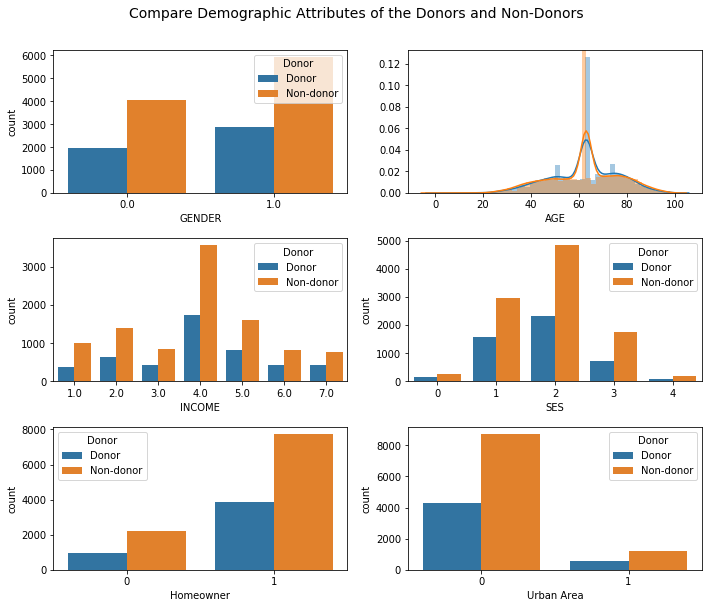

In [34]:
# Create plots
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (10,8))

sns.countplot(data = df_dummy, x = 'GENDER', hue = 'Donor', ax = ax1)

sns.distplot(df_dummy.loc[df_dummy.TARGET_B == 1]['AGE'], ax = ax2)
sns.distplot(df_dummy.loc[df_dummy.TARGET_B == 0]['AGE'], ax = ax2)

sns.countplot(data = df_dummy, x = 'INCOME', hue = 'Donor', ax = ax3)

sns.countplot(data = df_dummy, x = 'SES', hue = 'Donor', ax = ax4)

sns.countplot(data = df_dummy, x = 'HOMEOWNR_H', hue = 'Donor', ax = ax5)
ax5.set_xlabel('Homeowner')

sns.countplot(data = df_dummy, x = 'URBAN_U', hue = 'Donor', ax = ax6)
ax6.set_xlabel('Urban Area')

plt.suptitle('Compare Demographic Attributes of the Donors and Non-Donors', y = 1.05, fontsize = 14)
f.tight_layout()
plt.show()

The above charts show that there are no big differences in characteristics of donors (those who responded to the 97NK promotion), and non-donors (those who did not)

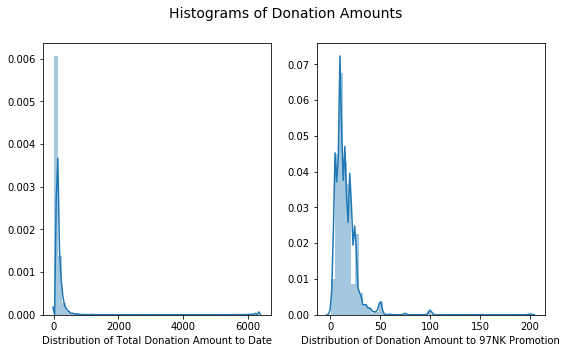

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,5))

#plt.scatter(x = df_dummy['INCOME'], y = df_dummy['RAMNTALL'], ax = ax1)
#ax1.set_xlabel('Income Level')
#ax1.set_ylabel('Dollar Amount of Lifetime Gift to Date')

sns.distplot(df_dummy.RAMNTALL, ax = ax1)
ax1.set_xlabel('Distribution of Total Donation Amount to Date')

sns.distplot(df_dummy.loc[df_dummy.TARGET_B == 1].TARGET_D, ax = ax2)
ax2.set_xlabel('Distribution of Donation Amount to 97NK Promotion')

# plt.scatter(x = df_dummy.AGE, y = df_dummy.AVGGIFT, ax = ax4)
# ax4.set_xlabel('Age')
# ax4.set_ylabel('Average Dollar Amount of Gifts to Date')
# ax4.set_ylim(0,200)

plt.suptitle('Histograms of Donation Amounts', fontsize = 14)
plt.show()

* Most people in the dataset gave between \$0 and \$500 in total amount of donations to date.
* Most people who responded to the 97NK promotion, most donated less than $50.

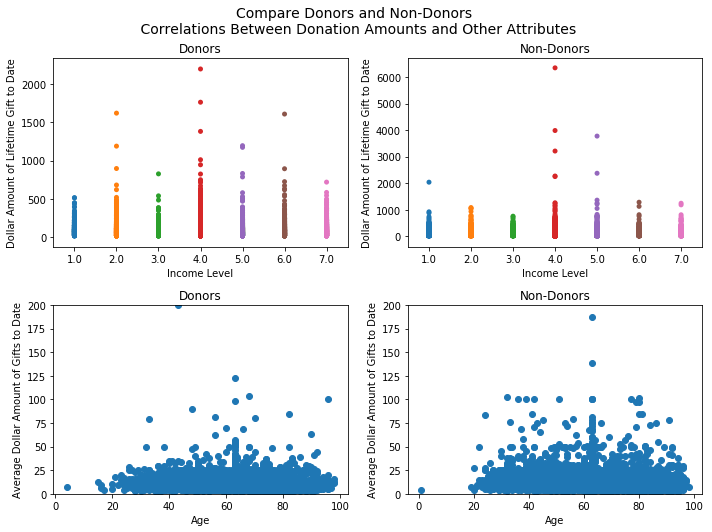

In [36]:
f = plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
sns.stripplot(x = 'INCOME', y = 'RAMNTALL', data =df_dummy.loc[df_dummy.TARGET_B == 1])
plt.xlabel('Income Level')
plt.ylabel('Dollar Amount of Lifetime Gift to Date')
plt.title('Donors')

plt.subplot(2,2,2)
sns.stripplot(x = 'INCOME', y = 'RAMNTALL', data =df_dummy.loc[df_dummy.TARGET_B == 0])
plt.xlabel('Income Level')
plt.ylabel('Dollar Amount of Lifetime Gift to Date')
plt.title('Non-Donors')

plt.subplot(2,2,3)
plt.scatter(x = df_dummy.loc[df_dummy.TARGET_B ==1].AGE, y = df_dummy.loc[df_dummy.TARGET_B ==1].AVGGIFT)
plt.xlabel('Age')
plt.ylabel('Average Dollar Amount of Gifts to Date')
plt.ylim(0,200)
plt.title('Donors')

plt.subplot(2,2,4)
plt.scatter(x = df_dummy.loc[df_dummy.TARGET_B ==0].AGE, y = df_dummy.loc[df_dummy.TARGET_B ==0].AVGGIFT)
plt.xlabel('Age')
plt.ylabel('Average Dollar Amount of Gifts to Date')
plt.ylim(0,200)
plt.title('Non-Donors')

plt.suptitle('Compare Donors and Non-Donors \n Correlations Between Donation Amounts and Other Attributes', 
             fontsize = 14, y = 1.05)
f.tight_layout()
plt.show()

- Looking at correlation between income and Total amount of donations to date, it appears that donors seem to give more than non-donors across all income levels.
- Looking at correlation between age and average donation amount, it appears that the average amount of donations has a higher range for non-donors than for donors.

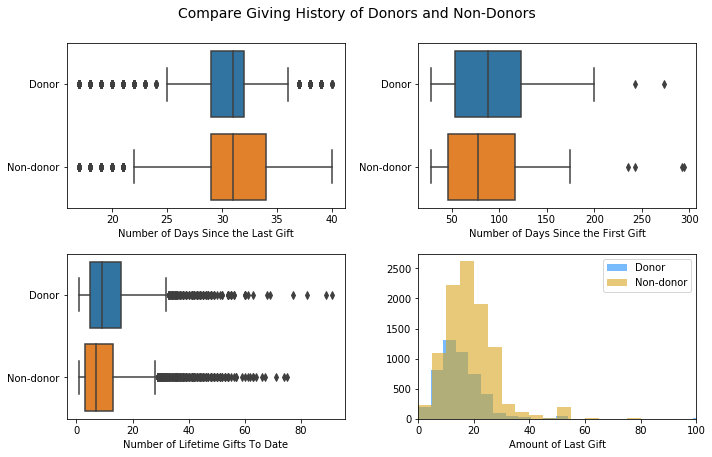

In [37]:
fig = plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
sns.boxplot(data = df_dummy, x = 'SINCE_LASTDATE', y = 'Donor')
plt.xlabel('Number of Days Since the Last Gift')
plt.ylabel('')

plt.subplot(2,2,2)
sns.boxplot(data = df_dummy, x = 'SINCE_FISTDATE', y = 'Donor')
plt.xlabel('Number of Days Since the First Gift')
plt.ylabel('')


plt.subplot(2,2,3)
sns.boxplot(data = df_dummy, x = 'NGIFTALL', y = 'Donor')
plt.ylabel('')
plt.xlabel('Number of Lifetime Gifts To Date')

plt.subplot(2,2,4)
plt.hist(df_dummy.loc[df_dummy.TARGET_B == 1].LASTGIFT,  label = 'Donor', color = 'dodgerblue', bins = 100, alpha = 0.6)
plt.hist(df_dummy.loc[df_dummy.TARGET_B == 0].LASTGIFT,  label = 'Non-donor', color = 'goldenrod', bins = 100, alpha = 0.6)
plt.legend(loc = 'upper right')
plt.xlabel('Amount of Last Gift')
plt.ylabel('')
plt.xlim(0,100)

plt.suptitle('Compare Giving History of Donors and Non-Donors', y = 1.05, fontsize = 14)
#ax2.set_xlim(0, 100)
fig.tight_layout()
plt.show()


* The number of days since the last gift are slightly less for donors than for non-donors. In other words, those who donated to the 97NK promotion seem to be those who donated more recently.
* The number of days since the first gift are slightly more for donors than for non-donors. In other words, thoe who donated to the 97NK promotion seem to be those who had been donating for a longer period of time.
* There are no big differences in the total number of gifts to date between donors and non-donors.
* The amount of the last gift of the donors seems slighlty less than that of non-donors, but no big difference.

# ** CLEAN DATA FROM HERE **

In [ ]:
# Import cleaned dataset (called df_dummy)
#df_dummy = pd.read_excel('Cleaned Dataset for KDD Data Challenge.xlsx')

# IV. Feature selection

In [38]:
# Assign X as a DataFrame of all features, and y_donate as a series of the outcome variable (whether donate or not), 
# and y_amount as a series of the outcome variable (amount of donation)
X = df_dummy.drop(['TARGET_B', 'TARGET_D', 'Donor'], axis = 1)
y_donate = df_dummy['TARGET_B']
y_amount = df_dummy['TARGET_D']
X.shape, y_donate.shape, y_amount.shape

((14843, 351), (14843,), (14843,))

### IV-1. Normalize the dataset

In [39]:
# Standardize the data to prepare for variance threshold feature selection
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X)
X_scaled = pd.DataFrame(minmax_scaler.transform(X), columns = X.columns)
#X_scaled.describe()

In [40]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_donate, train_size=0.70, random_state=123)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_donate, train_size=0.70, random_state=123)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print (X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)

(10390, 351) (4453, 351) (10390,) (4453,)
(10390, 351) (4453, 351) (10390,) (4453,)


C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### IV-2. Feature Selection Using Variance Threshold

In [41]:
# Remove all features whose variance are less than 0.05
var_selector = VarianceThreshold(threshold = 0.05)
var_selector.fit(X_train_scaled)
indices_selected = var_selector.get_support(indices=True)
colnames_vtselected = [X_train_scaled.columns[i] for i in indices_selected]
print(colnames_vtselected)
len(colnames_vtselected)

['CLUSTER', 'INCOME', 'GENDER', 'DATASRCE', 'POP90C1', 'POP90C2', 'POP90C3', 'DW1', 'DW2', 'DW4', 'DW5', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'RP1', 'RP2', 'RP3', 'RP4', 'LFC8', 'LFC9', 'HC2', 'HC5', 'HC6', 'HC7', 'HC8', 'HC11', 'HC13', 'HC17', 'HC18', 'HC19', 'HPHONE_D', 'RFA_2F', 'CLUSTER2', 'SINCE_ODATEDW', 'SINCE_MINRDATE', 'HOMEOWNR_H', 'HOMEOWNR_U', 'RFA_2A_D', 'RFA_2A_E', 'RFA_2A_F', 'RFA_2A_G', 'GEOCODE2_A', 'GEOCODE2_B', 'GEOCODE2_C', 'GEOCODE2_D', 'URBAN_C', 'URBAN_R', 'URBAN_S', 'URBAN_T', 'URBAN_U']


52

### IV-3. Further Feature Selection using RFECV

In [42]:
# Specify the model
estimator = LogisticRegression()    # estimator for RFE, select the suitable model 

# Select variables using RFECV
rfe_selector = RFECV(estimator, step=1, cv = 5, n_jobs = -1, scoring = 'roc_auc')
#rfe_selector = RFE(estimator, step = 1)
rfe_selector.fit(X_train[colnames_vtselected], y_train)


RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=-1, scoring='roc_auc', step=1, verbose=0)

In [43]:
# Show the variables selected by RFECV
rfe_selected = list(zip(rfe_selector.ranking_, rfe_selector.support_, colnames_vtselected))
rfe_selected = pd.DataFrame(rfe_selected, columns = ['Ranking', 'Support', 'Feature'])
rfe_selected.head()

,Ranking,Support,Feature
0,15,False,CLUSTER
1,1,True,INCOME
2,1,True,GENDER
3,1,True,DATASRCE
4,1,True,POP90C1


In [44]:
rfe_selected_var = list(rfe_selected[rfe_selected.Ranking == 1]['Feature'])
print(rfe_selected_var)

['INCOME', 'GENDER', 'DATASRCE', 'POP90C1', 'POP90C2', 'POP90C3', 'HVP1', 'HC2', 'HC7', 'HC8', 'RFA_2F', 'HOMEOWNR_H', 'HOMEOWNR_U', 'RFA_2A_D', 'RFA_2A_E', 'RFA_2A_F', 'RFA_2A_G', 'GEOCODE2_A', 'GEOCODE2_B', 'GEOCODE2_C', 'GEOCODE2_D', 'URBAN_C', 'URBAN_R', 'URBAN_S', 'URBAN_T', 'URBAN_U']


In [45]:
len(rfe_selected_var)

26

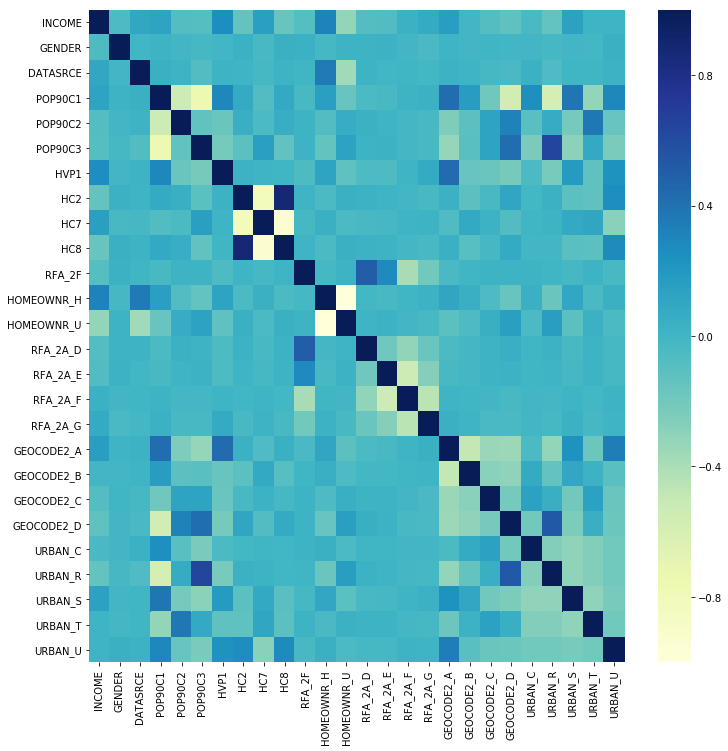

In [46]:
# Check correlation of the selected variables
_ = plt.figure(figsize = (12, 12))
_ = sns.heatmap(X[rfe_selected_var].corr(), cmap="YlGnBu")
plt.show()

# V. Task 1: Predict Who Will be Donors
### V-1. Logistic Regression

In [47]:
clflog = LogisticRegression()
parameters = {"C": [0.0001, 0.001, 0.1, 1, 10, 100]}
clflog = do_classify(clflog, parameters, X_train[rfe_selected_var], y_train, X_test[rfe_selected_var], y_test, 
                                            n_jobs = 4, score_func = 'f1')

Best parameters: {'C': 100}
Accuracy on training data: 0.68
Accuracy on test data:     0.67
Confusion Matrix:
[[2876  129]
 [1344  104]]
Classification Report:
               precision recall f1-score support
0            0      0.68   0.96     0.80    3005
1            1      0.45   0.07     0.12    1448
2  avg / total      0.61   0.67     0.58    4453
########################################################


### V-2. Decision Tree

In [48]:
clftree = tree.DecisionTreeClassifier()

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clftree = do_classify(clftree, parameters, X_train[rfe_selected_var], y_train, X_test[rfe_selected_var], y_test, 
                                            n_jobs = 4, score_func = 'f1')

Best parameters: {'max_depth': 7, 'min_samples_leaf': 2}
Accuracy on training data: 0.70
Accuracy on test data:     0.66
Confusion Matrix:
[[2753  252]
 [1282  166]]
Classification Report:
               precision recall f1-score support
0            0      0.68   0.92     0.78    3005
1            1      0.40   0.11     0.18    1448
2  avg / total      0.59   0.66     0.59    4453
########################################################


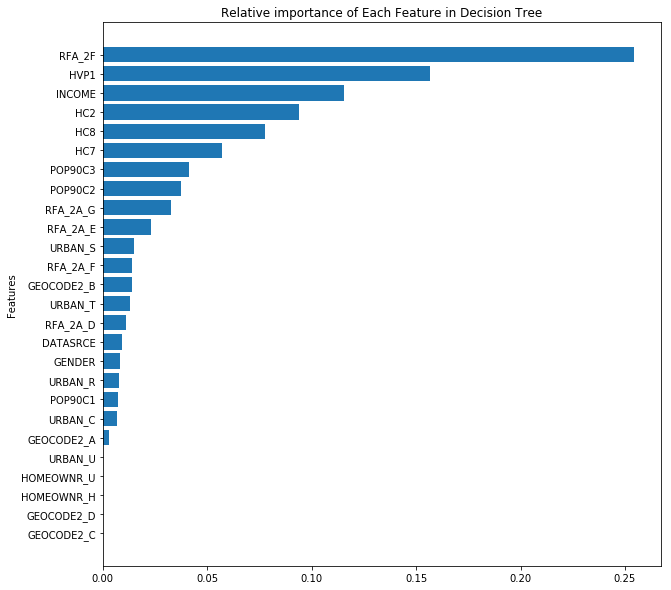

In [49]:
plot_feature_importance(clftree, rfe_selected_var, 'Decision Tree')

### V-3. Random Forest

In [50]:
clfForest = RandomForestClassifier()

parameters = {"n_estimators": range(1, 20)}
clfForest = do_classify(clfForest, parameters, X_train[rfe_selected_var], y_train, X_test[rfe_selected_var], y_test,
                                                             n_jobs = 4, score_func='f1')


Best parameters: {'n_estimators': 1}
Accuracy on training data: 0.84
Accuracy on test data:     0.57
Confusion Matrix:
[[2027  978]
 [ 928  520]]
Classification Report:
               precision recall f1-score support
0            0      0.69   0.67     0.68    3005
1            1      0.35   0.36     0.35    1448
2  avg / total      0.58   0.57     0.57    4453
########################################################


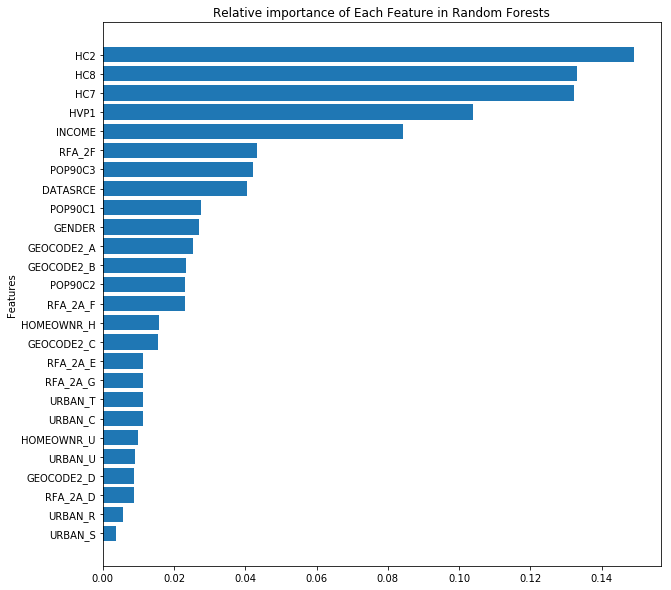

In [51]:
plot_feature_importance(clfForest, rfe_selected_var, 'Random Forests')

### V-4. Naive Bayes

In [52]:
clfnb=GaussianNB()
clfnb.fit(X_train[rfe_selected_var], y_train)
print (confusion_matrix(y_test, clfnb.predict(X_test[rfe_selected_var])))
print (clsf_df(y_test, clfnb.predict(X_test[rfe_selected_var])))

[[2403  602]
 [ 991  457]]
               precision recall f1-score support
0            0      0.71   0.80     0.75    3005
1            1      0.43   0.32     0.36    1448
2  avg / total      0.62   0.64     0.63    4453


### V-5. Compare all classifiers

In [53]:
# Put the total results of each classifier into a dataframe for easy comparison
clflog_total_res = clsf_df(y_test, clflog.predict(X_test[rfe_selected_var])).iloc[2]
clftree_total_res = clsf_df(y_test, clftree.predict(X_test[rfe_selected_var])).iloc[2]
clfForest_total_res = clsf_df(y_test, clfForest.predict(X_test[rfe_selected_var])).iloc[2]
clfnb_total_res = clsf_df(y_test, clfnb.predict(X_test[rfe_selected_var])).iloc[2]

all_classifiers_res = pd.concat([clflog_total_res, clftree_total_res, clfForest_total_res, clfnb_total_res], axis = 1)
all_classifiers_res.columns = ['Logistic Regression', 'Decision Tree', 'Random Forests', 'Naive Bayes']
all_classifiers_res

,Logistic Regression,Decision Tree,Random Forests,Naive Bayes
,avg / total,avg / total,avg / total,avg / total
precision,0.61,0.59,0.58,0.62
recall,0.67,0.66,0.57,0.64
f1-score,0.58,0.59,0.57,0.63
support,4453,4453,4453,4453


In [55]:
# Make ROC curve
plt.figure(figsize=  (10, 10))
ax = make_roc("Naive Bayes",clfnb, y_test, X_test[rfe_selected_var], None, labe=200)
make_roc("Decision Tree",clftree, y_test, X_test[rfe_selected_var], ax, labe=200)
make_roc("Logistic Regression",clflog, y_test, X_test[rfe_selected_var], ax,labe=200)
#make_roc("Random Forests",clfForest, y_test, X_test[rfe_selected_var], ax, labe=20)


# VI. Task 2: Predict Donation Amount 
### VI-1. Set Up the Data

In [56]:
# Get the predicted labels for all samples (both training and test sets) according to Naive Bayes model
predicted = clfnb.predict(X[rfe_selected_var]) #Use predictions from Naive Bayes model
predicted = pd.DataFrame(predicted)
predicted.columns = ['Predicted Donor']
predicted.shape

(14843, 1)

In [57]:
# Add y_amount (TARGET_D) back to X
X = pd.concat([X, y_amount], axis = 1)
X.head()

,CLUSTER,AGE,INCOME,GENDER,HIT,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,HPHONE_D,RFA_2F,CLUSTER2,SES,SINCE_ODATEDW,SINCE_MAXADATE,SINCE_MINRDATE,SINCE_MAXRDATE,SINCE_LASTDATE,SINCE_FISTDATE,SINCE_NEXTDATE,NOEXCH_0,NOEXCH_1,NOEXCH_X,HOMEOWNR_H,HOMEOWNR_U,RFA_2R_L,RFA_2A_D,RFA_2A_E,RFA_2A_F,RFA_2A_G,MDMAUD_R_C,MDMAUD_R_D,MDMAUD_R_I,MDMAUD_R_L,MDMAUD_R_X,MDMAUD_F_1,MDMAUD_F_2,MDMAUD_F_5,MDMAUD_F_X,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_T,MDMAUD_A_X,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,URBAN_C,URBAN_R,URBAN_S,URBAN_T,URBAN_U,TARGET_D
20,12.0,62.0,3.0,1.0,10,3.0,2,25,40,27,11,4,1,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12.0,4.066667,1,3,3.0,1,138,17,126,51,28,138,126.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,4.0
30,35.0,63.0,4.0,0.0,0,3.0,1,37,58,16,8,1,5,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9.0,6.181818,1,3,14.0,1,102,20,99,66,31,99,90.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,7.0
45,24.0,66.0,5.0,1.0,5

In [59]:
# Reset index in X_test and predicted df, then concatenate them into X_donor df
X_reset = X.reset_index(drop = True)
predicted_reset = predicted.reset_index(drop = True)
X_reset = pd.concat([X_reset, predicted_reset], axis = 1)
#X_donor = X_donor.loc[X_donor['Predicted Donor'] ==1]
#X_reset.head(10)

In [60]:
# Select only those who were predicted as '1':
X_donor = X_reset.loc[X_reset['Predicted Donor'] ==1]
X_donor.head()

,CLUSTER,AGE,INCOME,GENDER,HIT,DATASRCE,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,HPHONE_D,RFA_2F,CLUSTER2,SES,SINCE_ODATEDW,SINCE_MAXADATE,SINCE_MINRDATE,SINCE_MAXRDATE,SINCE_LASTDATE,SINCE_FISTDATE,SINCE_NEXTDATE,NOEXCH_0,NOEXCH_1,NOEXCH_X,HOMEOWNR_H,HOMEOWNR_U,RFA_2R_L,RFA_2A_D,RFA_2A_E,RFA_2A_F,RFA_2A_G,MDMAUD_R_C,MDMAUD_R_D,MDMAUD_R_I,MDMAUD_R_L,MDMAUD_R_X,MDMAUD_F_1,MDMAUD_F_2,MDMAUD_F_5,MDMAUD_F_X,MDMAUD_A_C,MDMAUD_A_L,MDMAUD_A_T,MDMAUD_A_X,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,URBAN_C,URBAN_R,URBAN_S,URBAN_T,URBAN_U,TARGET_D,Predicted Donor
0,12.0,62.0,3.0,1.0,10,3.0,2,25,40,27,11,4,1,2707,672,929,99,0,0,45,55,97,1,0,2,1,0,0,0,0,1,0,0,1,0,0,0,35,42,43,37,47,50,27,34,43,23,9,20,27,16,8,6,15,15,13,37,21,14,16,8,15,23,30,47,29,11,2,55,10,13,22,190,267,89,49,1,10,10,8,8,8,0,902,960,8,8,88,12,97,3,11,42,72,60,34,79,21,8,1,7,12,21,5,21,58,17,0,1,0,0,4,35,74,99,0,1,64,63,62,14,4,2,8,0,5,1,7,0,95,96,96,96,468,501,540,580,20328,6,8,19,23,23,11,7,1,2,4,6,13,27,25,14,8,1,1,14,2,66,1,61,39,20,74,17,2,2,0,0,0,2,4,1,75,20,21,1,67,71,82,62,80,60,80,65,99,0,1,21,20,8,11,17,1,1,10,0,5,3,2,1,0,0,3,23,5,2,4,12,7,3,2,1,14,12,7,5,11,4,1,4,70,10,0,140,5,3,24,21,9,32,7,3,23,3,16,7,1,2,0,12,25,3,40,20,27,7,0,0,2,12,0,0,3,1,4,1,0,0,0,4,0,1,58,95,1,0,4,95,69,23,4,13,2,17,35,91,99,1,12,3,93,0,5,1,0,1,99,1,97,99,99,9,2,6,3,26,65,5,12,61.0,15,10,2.0,7.0,5.0,12.0,4.066667,1,3,3.0,1,138,17,126,51,28,138,126.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,4.0,1
1,35.0,63.0,4.0,0.0,0,3.0,1,37,58,16,8,1,5,2147,591,640,99,0,0,49,51,94,2,0,3,5,1,0,1,1,0,0,0,3,0,0,2,29,36,37,27,38,40,37,46,37,17,8,34,34,15,6,2,1,18,21,31,19,11,5,0,3,7,23,71,47,15,6,77,5,1,17,286,334,99,99,0,0,0,0,0,0,0,1002,1166,7,5,97,3,96,4,3,63,92,88,59,97,3,4,1,3,5,4,1,30,60,4,1,2,0,4,15,50,94,99,2,0,91,70,72,20,4,0,0,0,3,0,0,0,78,83,99,99,633,638,652,663,19703,2,5,1,17,48,19,7,0,1,3,4,0,16,51,19,7,0,1,5,0,65,3,74,26,25,89,9,0,0,0,0,0,1,2,1,82,34,42,22,70,82,98,67,97,66,68,61,99,99,0,34,23,4,10,12,0,2,9,0,4,1,1,0,0,4,2,25,5,2,4,8,8,8,0,3,10,8,9,4,8,1,5,5,76,4,1,160,0,1,12,25,10,39,13,5,33,6,25,7,1,1,0,19,37,2,58,11,16,10,0,4,1,15,0,0,3,2,0,2,0,0,0,1,0,3,48,97,1,1,1,99,91,24,3,6,6,57,85,95,95,5,0,0,75,0,20,0,0,5,96,4,90,99,99,12,4,1,6,10,24,0,2,68.0,11,6,2.0,10.0,7.0,9.0,6.181818,1,3,14.0,1,102,20,99,66,31,99,90.0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,7.0,1
2,24

In [61]:
X_donor.shape #3481 people predicted to be donors according to Naive Bayes

(3481, 353)

In [66]:
# Split above df to train and test sets to use later for regression models
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_donor.drop(['TARGET_D', 'Predicted Donor'], axis = 1), 
                                                        X_donor.TARGET_D,
                                                       test_size = 0.3, random_state = 123)

print(X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape)

(2436, 351) (1045, 351) (2436,) (1045,)


### VI-1. Feature Selection Again for Regression Task

In [67]:
# RFE again to select the best features needed for regression task.
# Specify the model
estimator = LinearRegression()  

# Select variables using RFECV
rfe_selector1 = RFECV(estimator, step=1, cv = 5, n_jobs = -1, scoring = 'r2')
rfe_selector1.fit(X_train1[colnames_vtselected], y_train1) #Use the columns selected by Variance Threshold as in task 1

# Show the variables selected by RFECV
rfe_selected1 = list(zip(rfe_selector1.ranking_, rfe_selector1.support_, colnames_vtselected))
rfe_selected1 = pd.DataFrame(rfe_selected1, columns = ['Ranking', 'Support', 'Feature'])
rfe_selected1.head()

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=-1, scoring='r2', step=1, verbose=0)

In [69]:
# Select all the features where ranking = 1
rfe_selected_var1 = list(rfe_selected1[rfe_selected1.Ranking == 1]['Feature'])
print(rfe_selected_var1)

['HOMEOWNR_H', 'RFA_2A_D', 'RFA_2A_E', 'RFA_2A_F', 'RFA_2A_G', 'GEOCODE2_A', 'GEOCODE2_D']


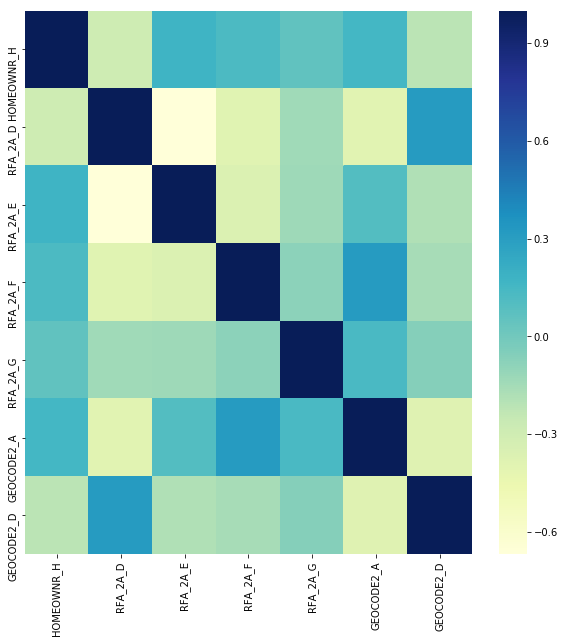

In [71]:
# Check correlation of the selected variables
_ = plt.figure(figsize = (10, 10))
_ = sns.heatmap(X_donor[rfe_selected_var1].corr(), cmap="YlGnBu")
plt.show()

### VI - 3. Linear Regression Model

In [72]:
lm = LinearRegression()
results_linear = do_regress(lm, X_train1[rfe_selected_var1], y_train1, X_test1[rfe_selected_var1], y_test1)

### VI-4. Ridge Regression

In [73]:
ridge = Ridge()
param_ridge = {'alpha': [0.5, 0.2, 0.1, 0.01, 0.001, 0.0001]}
results_ridge = do_regress(ridge, X_train1[rfe_selected_var1], y_train1, X_test1[rfe_selected_var1], y_test1,
                           parameters=param_ridge)


Best parameters: {'alpha': 0.5}


### VI-5. Lasso Regression

In [74]:
lasso = Lasso()
param_lasso = {'alpha': [0.5, 0.2, 0.1, 0.01, 0.001, 0.0001]}
results_lasso = do_regress(lasso, X_train1[rfe_selected_var1], y_train1, X_test1[rfe_selected_var1], y_test1, 
                           parameters=param_lasso)

Best parameters: {'alpha': 0.01}


### VI-6. Elastic Net

In [75]:
l1_space = np.linspace(0, 1, 10)
param_en = {'l1_ratio': l1_space}
en = ElasticNet()
results_en = do_regress(en, X_train1[rfe_selected_var1], y_train1, X_test1[rfe_selected_var1], y_test1, parameters=param_en)

C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_

Best parameters: {'l1_ratio': 0.0}


C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_

### VI-7. Regression Tree

In [76]:
param_rt = {"max_depth": [1, 2, 3, 4, 5, 6, 7], 'min_samples_leaf': [4, 5, 6,7,8,9,10]}
regtree = DecisionTreeRegressor()
results_rt = do_regress(regtree, X_train1[rfe_selected_var1], y_train1, X_test1[rfe_selected_var1], y_test1,
                        parameters=param_rt)

Best parameters: {'max_depth': 4, 'min_samples_leaf': 4}


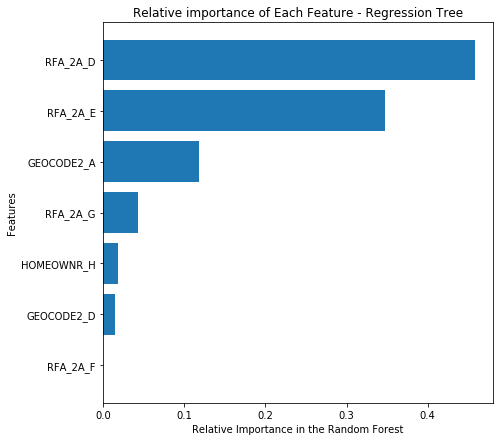

In [88]:
regtree = regtree.fit(X_train1[rfe_selected_var1], y_train1)

importance_list = regtree.feature_importances_
name_list = rfe_selected_var1
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))

plt.figure(figsize = (7, 7))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature - Regression Tree')
plt.show()

### VI-8. Compare Results of All Models

In [89]:
# Create a dataframe to compare results of all models
results_all = list(zip(results_linear, results_ridge, results_lasso, results_en, results_rt))
results_all = pd.DataFrame(results_all, columns = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net', 'Regression Tree'],
                          index = ['R-squared (training)', 'R-squared (test)', 'Root Mean Squared Error'])
results_all

,Linear Regression,Ridge,Lasso,Elastic Net,Regression Tree
R-squared (training),0.072547,0.071569,0.071606,0.028752,0.070558
R-squared (test),0.082128,0.082695,0.080369,0.019112,0.093009
Root Mean Squared Error,7.665311,7.662945,7.672655,7.924074,7.619742


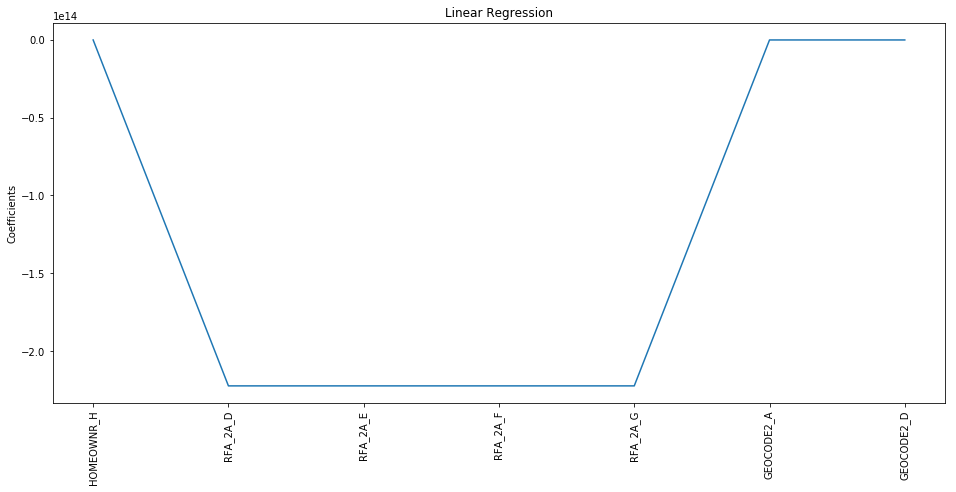

In [82]:
# Plot coefficients for Linear Regression
lm = LinearRegression()
_ = plot_coef('Linear Regression', lm, X_train1[rfe_selected_var1], y_train1)
plt.show()

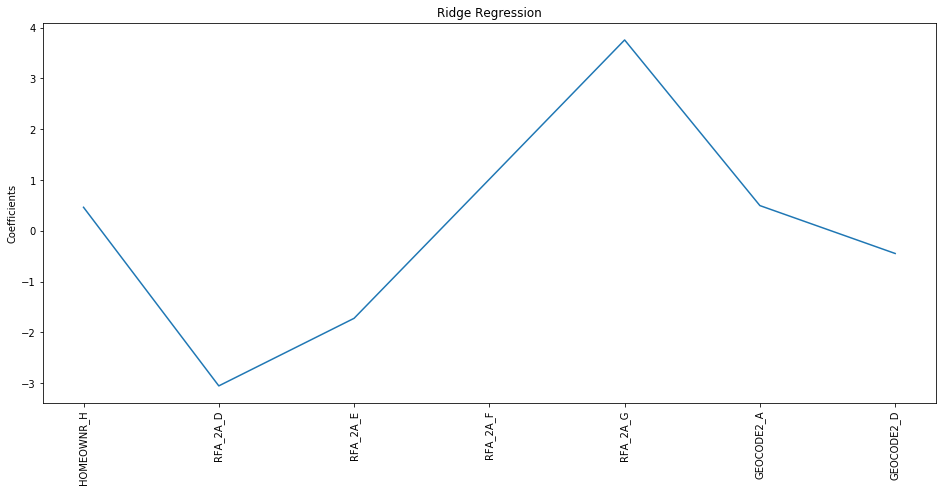

In [83]:
# Plot coefficients for RIdge Regression
ridge = Ridge(alpha = 0.5)
_ = plot_coef('Ridge Regression', ridge, X_train1[rfe_selected_var1], y_train1)
plt.show()

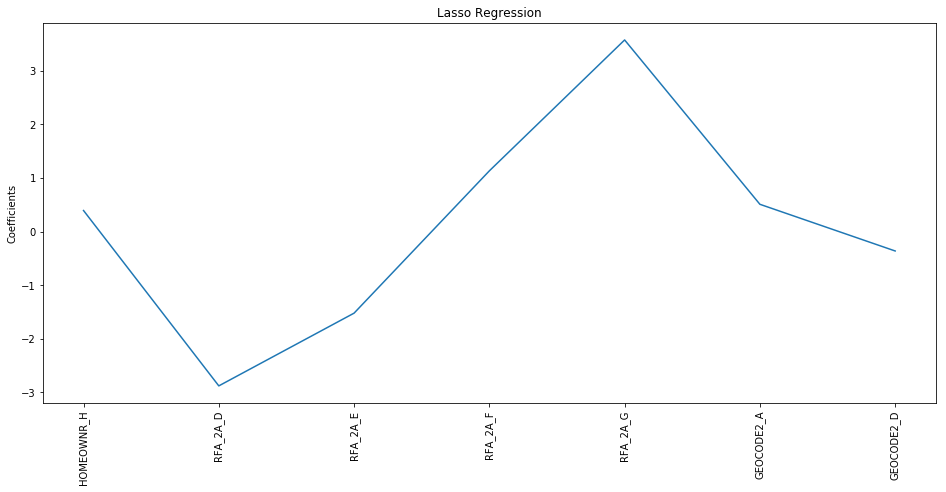

In [84]:
# Plot coefficients for Lasso Regression
lasso = Lasso(alpha = 0.01)
_ = plot_coef('Lasso Regression', lasso, X_train1[rfe_selected_var1], y_train1)
plt.show()

C:\Users\TLe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


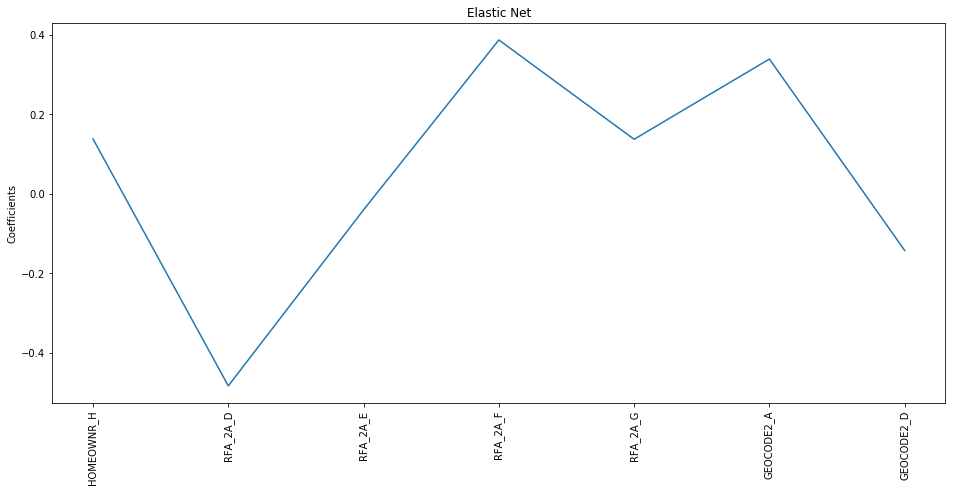

In [85]:
# Plot coefficients for Elastic Net
en = ElasticNet(l1_ratio= 0)
_ = plot_coef('Elastic Net', en, X_train1[rfe_selected_var1], y_train1)
plt.show()